# Long Short Time Memory Layer at EEG and BOLD embeddings

## Add an LSTM to add time series concept

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
activation=''

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(50, 2607, 7)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(100, 2607, 7)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(150, 2607, 7)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(200, 2607, 7)
Extracting parameters from /home/davidcalhas/e

In [2]:
eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, f_resample=f_resample,
                                                                roi=1, roi_ica_components=20)

#standardize data
eeg_train, bold_train, eeg_scaler, bold_scaler = data_utils.standardize(eeg_train, bold_train)
eeg_val, bold_val, _, _ = data_utils.standardize(eeg_val, bold_val, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

n_voxels = bold_train.shape[1]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y = data_utils.create_eeg_bold_pairs(eeg_train, bold_train)
X_val_eeg, X_val_bold, tv_y = data_utils.create_eeg_bold_pairs(eeg_val, bold_val)


X_train_eeg = X_train_eeg.astype(np.float32)
X_train_bold = X_train_bold.astype(np.float32)
X_val_eeg = X_val_eeg.astype(np.float32)
X_val_bold = X_val_bold.astype(np.float32)


tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=20)

eeg_test, bold_test, _, _ = data_utils.standardize(eeg_test, bold_test, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 2607, 14)
Extracting parameters from /home/davidcalhas

### Load and mutate the network 

In [3]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

print(eeg_network.summary())
print(bold_network.summary())

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, lstm=True, dcca=False)

Model: "sequential_315"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_transpose_105 (Conv3D (None, 144, 5, 14, 1)     82        
_________________________________________________________________
reshape_105 (Reshape)        (None, 720, 14, 1)        0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_316"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 720, 14, 1)        451       
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________
None


### Train Network

In [4]:
validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=64, 
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name = "LComb"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Encoder Loss:  0.07714117  || Decoder Loss:  -0.021912377 Validation Decoder Loss:  -0.5715148
Encoder Loss:  0.061720632  || Decoder Loss:  -0.023757648 Validation Decoder Loss:  -0.5658565
Encoder Loss:  0.056350082  || Decoder Loss:  -0.025250953 Validation Decoder Loss:  -0.56060094
Encoder Loss:  0.053695753  || Decoder Loss:  -0.026581978 Validation Decoder Loss:  -0.55447406
Encoder Loss:  0.051609706  || Decoder Loss:  -0.027868582 Validation Decoder Loss:  -0.5468502
Encoder Loss:  0.048756767  || Decoder Loss:  -0.029114401 Validation Decoder Loss:  -0.5392937
Encoder Loss:  0.046091486  || Decoder Loss:  -0.030296281 Validation Decoder Loss:  -0.53285193
Encoder Loss:  0.045385476  || Decoder Loss:  -0.03142808 Validation Decoder Loss:  -0.5256158
Encoder Loss:  0.045167506  || Decoder Loss:  -0.03251794 Validation Decoder Loss:  -0.5187097
Encoder Loss:  0.04574862  || Decoder Loss

ResourceExhaustedError: OOM when allocating tensor with shape[144,36498] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

train set mean:  -0.053473973786691206
train set std:  0.05626827139908614
validation set mean:  -0.15241338912397623
validation set std:  0.09467391388057214
test set mean:  -0.21462532050441951
test set std:  0.11036028299895345


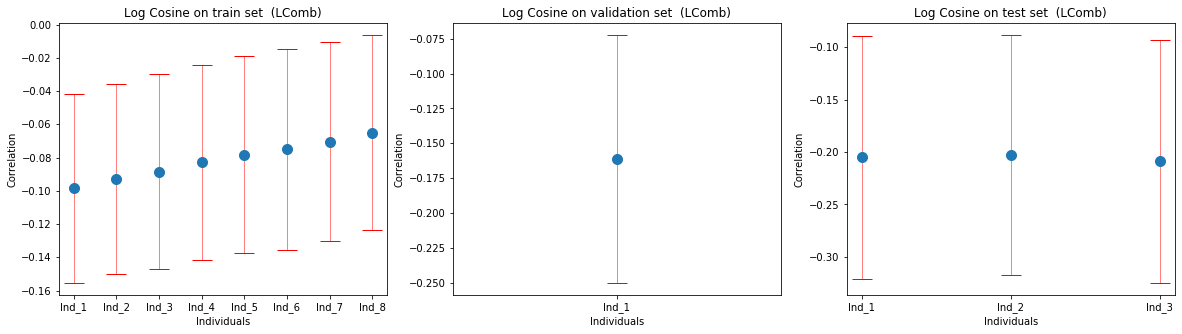

train set mean:  0.0505971230504947
train set std:  0.05186074085836113
validation set mean:  0.137575611397624
validation set std:  0.07966491355548652
test set mean:  0.18814717817120255
test set std:  0.0918116692791483


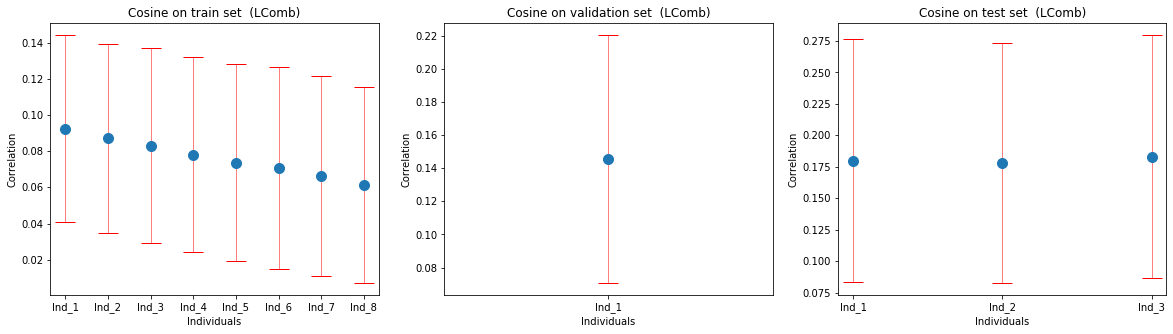

train set mean:  98987.3272578125
train set std:  75764.06108692766
validation set mean:  90598.416640625
validation set std:  59468.25944988721
test set mean:  122810.3908984375
test set std:  67912.66364097879


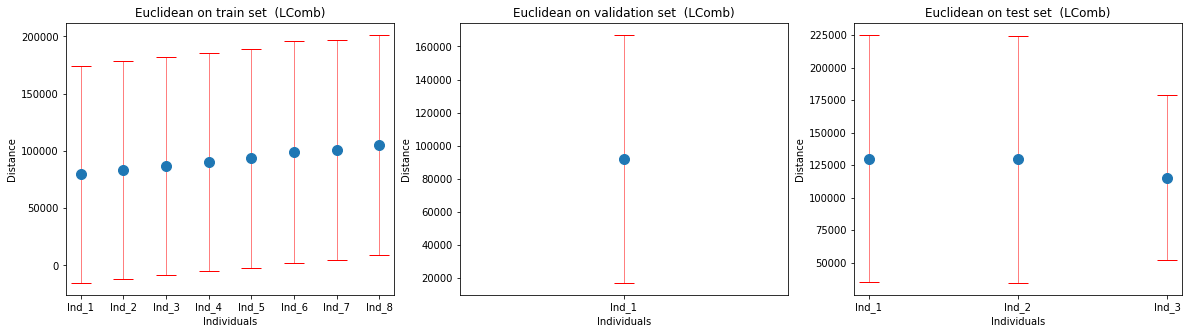

In [6]:
import utils.viz_utils as viz
model_name="LComb"


viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

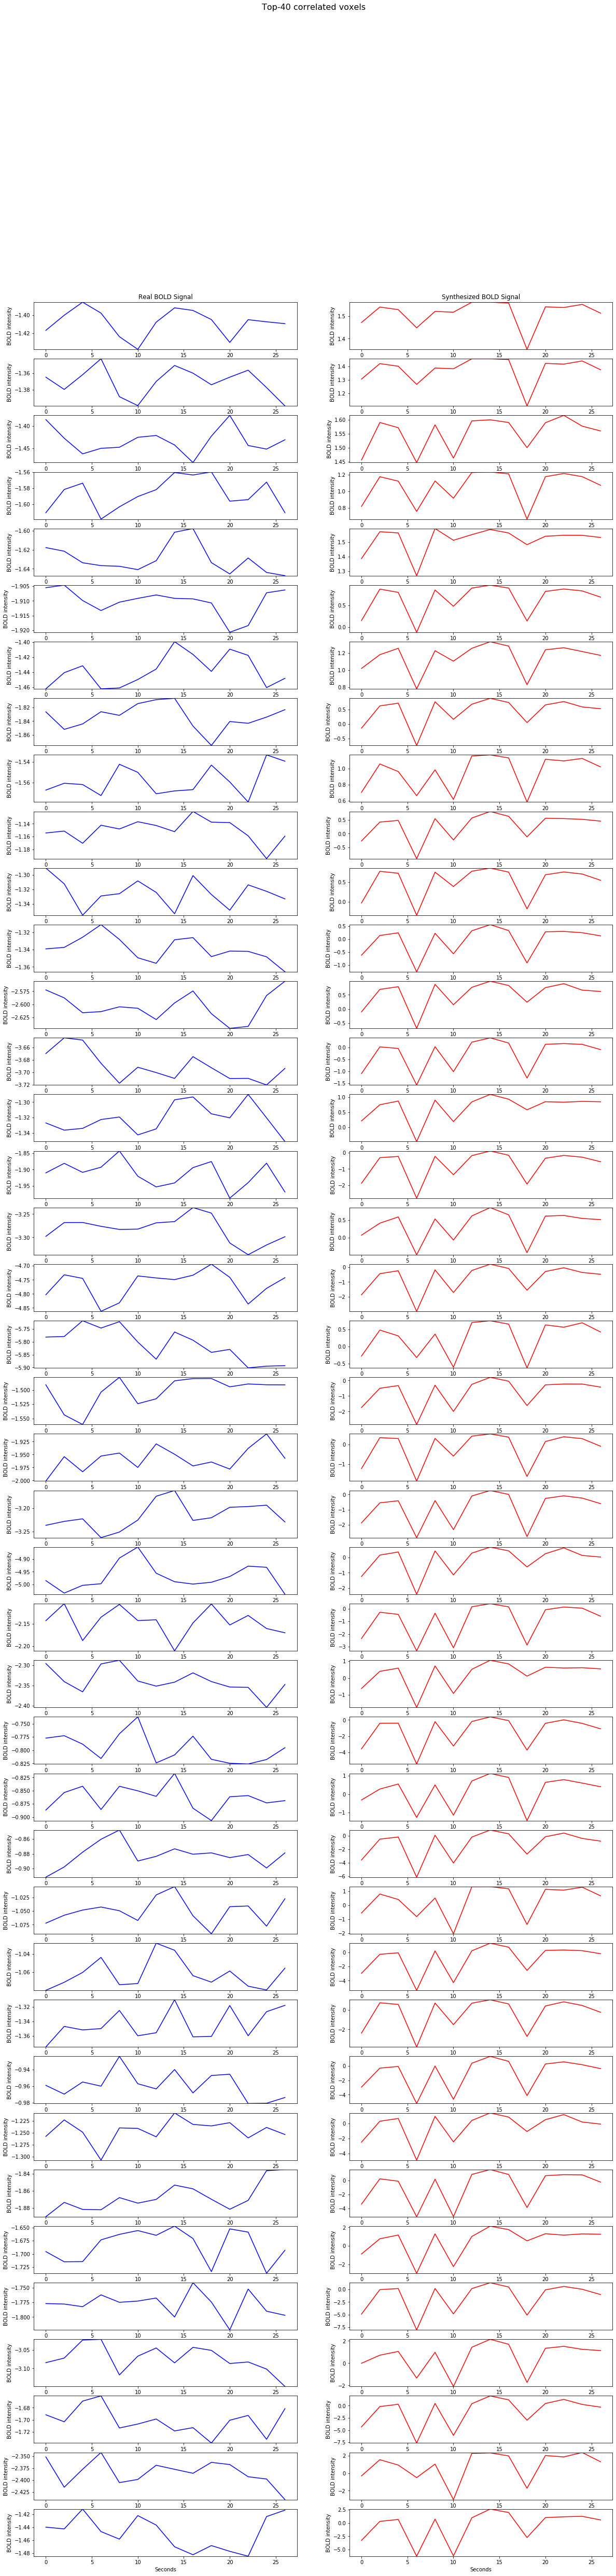

In [8]:
eeg_set = eeg_val
bold_set = bold_val

top_k = 40

#top_voxels = rank_best_synthesized_voxels(bold_set[individual], decoder_network(eeg_network(eeg_set))[individual].numpy(), top_k=top_k)

global_shape = (bold_set.shape[0]*bold_set.shape[1], bold_set.shape[2], bold_set.shape[3])
individual = None
top_voxels = viz.rank_best_synthesized_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape), top_k=top_k)

viz._plot_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape),
             individual=individual, voxels=top_voxels)
